In [1]:
import pandas.io.sql as psql
import psycopg2
import pandas as pd
import numpy as np

import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

plt.rcParams['figure.figsize'] = 11, 7
plt.rcParams['axes.grid'] = True
plt.pink()

<Figure size 792x504 with 0 Axes>

In [2]:
DB_HOST = "localhost"
DB_NAME = "dom.rf_db"
DB_USER = "postgres"
DB_PASS = "1234"

conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASS, host=DB_HOST)

In [3]:
# Выгружаем таблицу новостроек
new_buildings = psql.read_sql('SELECT * FROM new_building', conn)
new_buildings.head(3)

,obj_id,dev_id,obj_addr,obj_floor_min,obj_floor_max,obj_completion_date,objsquareliving,latitude,longitude,build_type
0,13383,306,г Тюмень,4,20,2022-12-31,6293.78,57.1519,65.5536,Жилое
1,13397,306,"г Тюмень, ул Профсоюзная, д. 56",6,12,2024-12-31,6248.51,57.1519,65.5544,Жилое
2,13399,306,"г Тюмень, ул Профсоюзная, д. 56",1,1,2024-12-31,0.00,57.1519,65.5544,Нежилое


In [4]:
new_buildings.shape

(10345, 10)

In [5]:
reestr = psql.read_sql('SELECT * FROM reestr', conn)
reestr.head(3)

,dev_id,dev_short_name,build_obj,comiss_obj,dev_site,dev_fact_addr,dev_region_code
0,7424,212-2,0,0,taganrogjsk.wixsite.com,обл Ростовская город Таганрог улица Сергея Шил...,61
1,306,2МЕН ГРУПП,5,0,2mengroup.ru,"Тюменская область, город Тюмень, улица Комсомо...",72
2,8382,79/23,0,0,www.наш.дом.рф,"обл Волгоградская, г Волжский, улица Им Космон...",34


In [6]:
reestr.shape

(4399, 7)

Проверять на наличие дубликатов и пустых значений не имеет смысла, т. к. это было проделано на предыдущем шаге. Сейчас мы сразу можем перейти к разведочному анализу данных (EDA).

## Разведочный анализ данных
### Таблица new_buildings

Так как явного задания у нас нет, возможно представить в качестве целевой переменной площадь объекта (**objsquareliving**).

In [7]:
# Основные статистики для квадратной площади объекта
new_buildings['objsquareliving'].describe()

count     10345.000000
mean       9436.425759
std       11389.007008
min           0.000000
25%        2131.200000
50%        6482.510000
75%       12442.800000
max      142978.700000
Name: objsquareliving, dtype: float64

In [8]:
new_buildings['obj_floor_min'].describe()

count    10345.000000
mean        10.513581
std          7.758938
min          0.000000
25%          4.000000
50%          9.000000
75%         16.000000
max         76.000000
Name: obj_floor_min, dtype: float64

Здесь мы видим экстремально большую разницу между 75-ым перцентилем и максимумом. Это говорит нам о наличии выбросов.

In [9]:
new_buildings['obj_floor_max'].describe()

count    10345.000000
mean        12.534171
std          8.434545
min          0.000000
25%          5.000000
50%         11.000000
75%         18.000000
max         76.000000
Name: obj_floor_max, dtype: float64

Та же тенденция с выбросами прослеживается и здесь.

**Посмотрим на некоторые гистограммы**:

1. Соотношение категорий жилых и нежилых домов

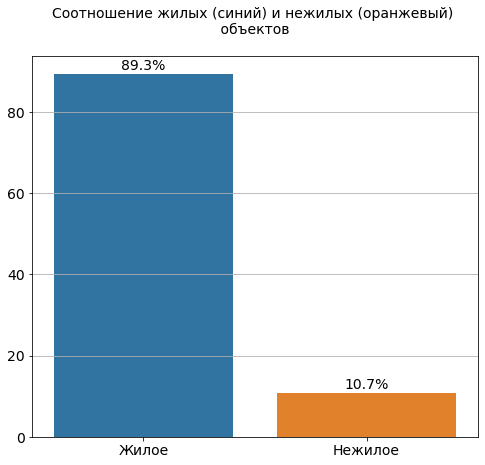

In [10]:
# Посмотрим распределение значений в переменной build_type
norm_target = (new_buildings
               .build_type
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(8, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

# Вывод значений над графиками - annotate()
# В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center', # центрирование
                va='center',
                xytext=(0, 9),
                textcoords='offset points', # точка смещения относительно координаты
                fontsize=14)

plt.title('Соотношение жилых (синий) и нежилых (оранжевый) \n объектов \n', fontsize=14)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Как видим, жилых объектов в данной выборке большинство. Застройщики ориентированы на физических лиц.

Теперь оценим взаимную корреляцию признаков.

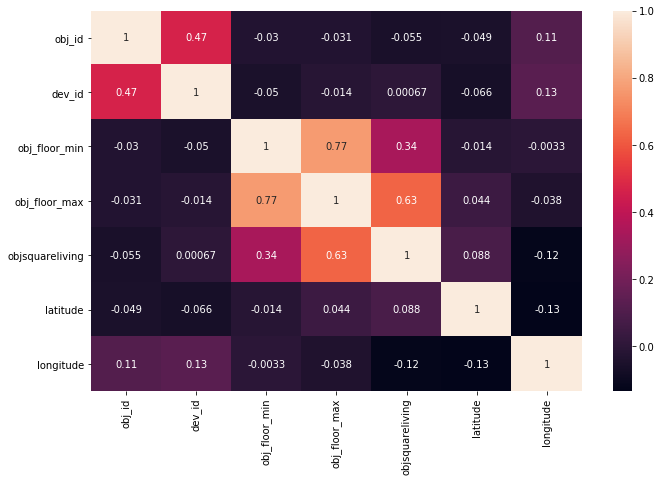

In [11]:
heatmap(new_buildings.corr(), annot=True)

С целевой переменной (**objsquareliving**) наиболее сильно коррелирует атрибут, отвечающий за количество этажей в новостройке.

Посмотрим отдельно разброс значений данной переменной относительно целевой.

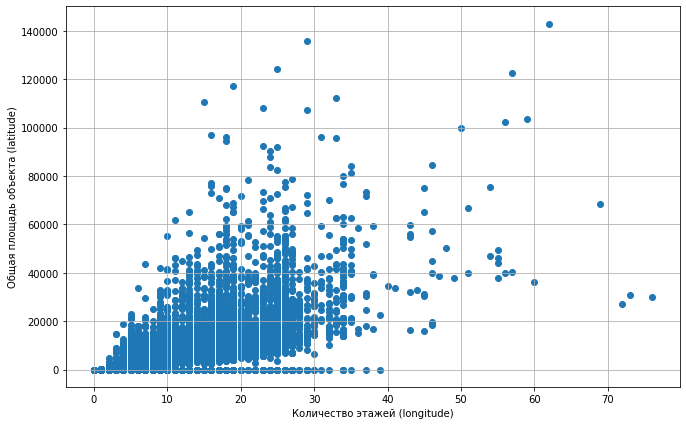

In [12]:
plt.scatter(x=new_buildings['obj_floor_max'], y=new_buildings['objsquareliving'])
plt.xlabel("Количество этажей (longitude)")
plt.ylabel("Общая площадь объекта (latitude)")
plt.show()

### Таблица reestr
Поработаем с таблицей застройщиков.
1. Посмотрим метрики, связанные с построенными объектами (build_obj).
2. Посмотрим, какие регионы встречаются чаще всех.

In [13]:
# 1
reestr['build_obj'].describe()

count    4399.000000
mean        2.353489
std         4.933328
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       148.000000
Name: build_obj, dtype: float64

Здесь явные выбросы - какие-то компании являются "рекордсменами" по застройке.

In [14]:
# 2
reestr['dev_region_code'].mode()

0    77
dtype: int64

Подгрузим таблицу с регионами и выведем 10 наиболее часто встречающихся регионов по застройщикам.

In [15]:
region = psql.read_sql('SELECT * FROM region', conn)
region.head(3)

,region_code,region_name
0,61,Ростовская область
1,72,Тюменская область
2,34,Волгоградская область


In [16]:
ten_regions_devs = reestr['dev_region_code'].value_counts()
ten_regions_devs = ten_regions_devs[:10]
ten_regions_devs = ten_regions_devs.reset_index()

print(ten_regions_devs)

   index  dev_region_code
0     77              430
1     50              263
2     23              232
3     78              226
4     54              176
5      2              148
6     66              131
7     16              110
8     39              106
9     61               99


In [17]:
ten_regions_devs.join(region.set_index('region_code'), on='index')

,index,dev_region_code,region_name
0,77,430,Москва город
1,50,263,Московская область
2,23,232,Краснодарский край
3,78,226,Санкт-Петербург город
4,54,176,Новосибирская область
5,2,148,Башкортостан Республика
6,66,131,Свердловская область
7,16,110,Татарстан Республика
8,39,106,Калининградская область
9,61,99,Ростовская область


Как видно, наибольшее количество застройщиков отвечает за Москву, Московскую область, Краснодарский край и Санкт-Петербург.

### Создание и тестирование моделей
Теперь попробуем создать модель линейной регрессии, которая будет предсказывать общую площадь объекта на основе имеющихся метрик.

Предварительно присоединим к итоговой таблице количество построенных объектов.

In [18]:
new_buildings = new_buildings.join(reestr.set_index('dev_id'), on='dev_id')
new_buildings.head(3)

,obj_id,dev_id,obj_addr,obj_floor_min,obj_floor_max,obj_completion_date,objsquareliving,latitude,longitude,build_type,dev_short_name,build_obj,comiss_obj,dev_site,dev_fact_addr,dev_region_code
0,13383,306,г Тюмень,4,20,2022-12-31,6293.78,57.1519,65.5536,Жилое,2МЕН ГРУПП,5,0,2mengroup.ru,"Тюменская область, город Тюмень, улица Комсомо...",72
1,13397,306,"г Тюмень, ул Профсоюзная, д. 56",6,12,2024-12-31,6248.51,57.1519,65.5544,Жилое,2МЕН ГРУПП,5,0,2mengroup.ru,"Тюменская область, город Тюмень, улица Комсомо...",72
2,13399,306,"г Тюмень, ул Профсоюзная, д. 56",1,1,2024-12-31,0.00,57.1519,65.5544,Нежилое,2МЕН ГРУПП,5,0,2mengroup.ru,"Тюменская область, город Тюмень, улица Комсомо...",72


In [19]:
# Удалим лишние колонки
new_buildings.drop(['obj_id', 'dev_id', 'obj_addr', 'obj_completion_date',
                    'dev_site', 'dev_fact_addr', 'dev_short_name', 'dev_region_code'], axis=1, inplace=True)
new_buildings.head(3)

,obj_floor_min,obj_floor_max,objsquareliving,latitude,longitude,build_type,build_obj,comiss_obj
0,4,20,6293.78,57.1519,65.5536,Жилое,5,0
1,6,12,6248.51,57.1519,65.5544,Жилое,5,0
2,1,1,0.00,57.1519,65.5544,Нежилое,5,0


In [20]:
new_buildings = pd.get_dummies(new_buildings, columns=['build_type'], drop_first=True)
new_buildings.head(3)

,obj_floor_min,obj_floor_max,objsquareliving,latitude,longitude,build_obj,comiss_obj,build_type_Нежилое
0,4,20,6293.78,57.1519,65.5536,5,0,0
1,6,12,6248.51,57.1519,65.5544,5,0,0
2,1,1,0.00,57.1519,65.5544,5,0,1


Повторно посмотрим на корреляции.

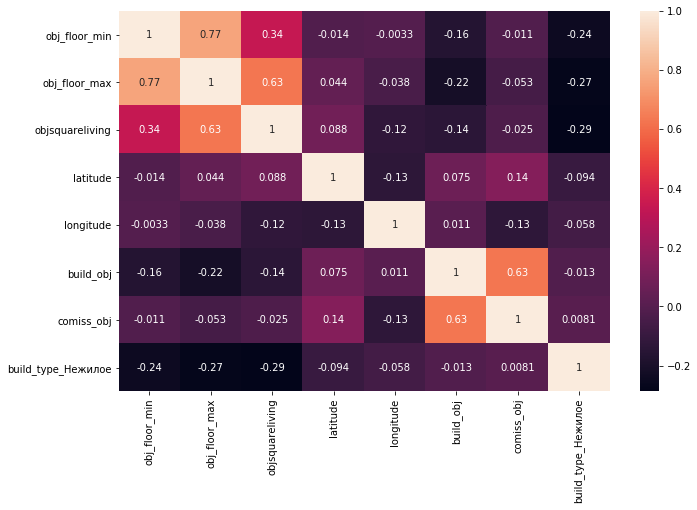

In [21]:
heatmap(new_buildings.corr(), annot=True)

Новых зависимостей не было выявлено, поэтому спокойно разделяем датасет на тренировочное и тестовое множества.

In [22]:
Y = new_buildings.objsquareliving
X = new_buildings.drop(['objsquareliving'], axis=1)

In [23]:
# Тренировочный и тестовый наборы
seed = 12

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    shuffle=True)

In [24]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)

prediction_1 = linear_reg.predict(X_test)
MAE_1 = mean_absolute_error(Y_test, prediction_1)

print("R2 на тестовом наборе: %0.5f" % linear_reg.score(X_test, Y_test))
print("MAE на тестовом наборе: %0.5f" % MAE_1)

R2 на тестовом наборе: 0.45444
MAE на тестовом наборе: 4867.16022


In [25]:
k = 3
cv_linear_reg = cross_validate(linear_reg, X, Y,
                       cv = 5,
                       scoring = ('r2', 'neg_mean_absolute_error'))


print("Среднее значение R2 для линейной регрессии с применением кросс-валидации при", k, ": %0.5f" % cv_linear_reg['test_r2'].mean())
print("Среднее значение MAE для линейной регрессии с применением кросс-валидации при", k, ": %0.5f" % -cv_linear_reg['test_neg_mean_absolute_error'].mean())

Среднее значение R2 для линейной регрессии с применением кросс-валидации при 3 : 0.47500
Среднее значение MAE для линейной регрессии с применением кросс-валидации при 3 : 4888.32953


Предполагается, что при изменении вида распределений ниже можно достичь лучшего предсказательного результата.

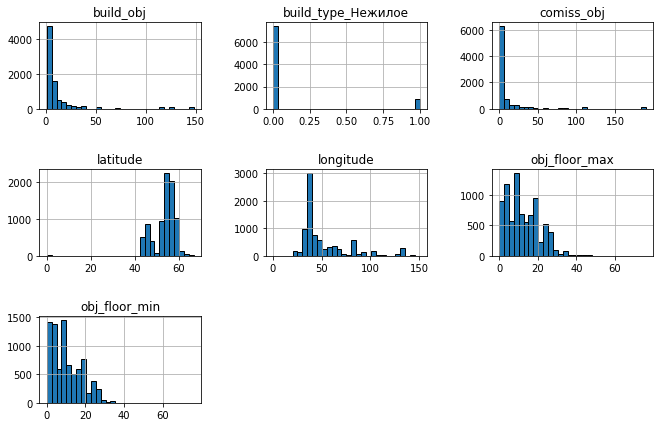

In [26]:
X_train.iloc[:, :].hist(bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)